## Introduction

Need to answer the questions:
- What is the machine learning problem you are trying to solve?
- Why does the problem matter?
- What could the results of your predictive model be used for?
- Why would we want to be able to predict the thing you're trying to preduct?
- Describe the dataset.

We can use the music composition of the song (acousticness, speechiness, key) to predict its popularity and the number of streams that it will have.

In [42]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv("spotify-2023.csv", thousands=',')
raw_data = data

### 1. Data Prep
#### 1.1 Data Cleaning
Impute missing values 
- Missing keys:
    
    On review of the songs with missing keys, a majority are C, so all missing keys have been entered as C.
- Missing in_shazam_charts rankings:
    
    Imputing a value of 0, as these songs most likely did not land in shazam charts

In [43]:
# Fill in NaNs in the key column with C and the NaNs in in_shazam_charts with 0
data['key'] = data['key'].fillna("C")
shazamMean = data['in_shazam_charts'].mean(skipna=True)
data['in_shazam_charts'] = data['in_shazam_charts'].fillna(shazamMean)

# Ensure no more NaNs in data
data.isnull().values.any()

False

One-Hot encode categorical values
- Key
- Mode

In [44]:
# Modify keys
one_hot = pd.get_dummies(data['key'])
data = data.drop('key',axis = 1)
data = data.join(one_hot)

# Modify modes -- binary: Minor vs not-minor
one_hot = pd.get_dummies(data['mode'], drop_first=True)
data = data.drop('mode',axis = 1)
data = data.join(one_hot)

print(data.head())

                            track_name    artist(s)_name  artist_count  \
0  Seven (feat. Latto) (Explicit Ver.)  Latto, Jung Kook             2   
1                                 LALA       Myke Towers             1   
2                              vampire    Olivia Rodrigo             1   
3                         Cruel Summer      Taylor Swift             1   
4                       WHERE SHE GOES         Bad Bunny             1   

   released_year  released_month  released_day  in_spotify_playlists  \
0           2023               7            14                   553   
1           2023               3            23                  1474   
2           2023               6            30                  1397   
3           2019               8            23                  7858   
4           2023               5            18                  3133   

   in_spotify_charts    streams  in_apple_playlists  ...      C     C#      D  \
0                147  141381703          

#### 1.2 Data Exploration

The goal is to find what features may have the largest affect on the number of streams and the popularity of a song. 
One of the easiest ways to see this is through a correlation chart.

In [45]:
# Notable correlations with streams: 
#   in_spotify_playlists, in_apple_playlists, in_apple_charts, in_spotify_charts
data.corr(numeric_only=True)

,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,in_deezer_playlists,...,C,C#,D,D#,E,F,F#,G,G#,Minor
artist_count,1.000000,0.087586,0.037995,-0.017549,-0.101966,-0.018507,-0.135791,-0.051074,-0.088597,-0.071506,...,0.016351,0.032825,-0.033923,0.010593,-0.035658,-0.014126,-0.011484,0.021915,-0.026436,0.094893
released_year,0.087586,1.000000,0.076714,0.174282,-0.392204,0.069678,-0.224320,-0.198998,-0.035842,-0.306812,...,-0.000829,-0.009276,-0.043787,-0.009226,0.021151,0.032718,-0.019669,-0.029769,0.006853,0.089473
released_month,0.037995,0.076714,1.000000,0.080313,-0.104757,-0.047623,-0.023571,-0.000164,-0.019064,-0.088004,...,0.006692,-0.000913,-0.009205,0.017537,0.036904,-0.009093,-0.039239,0.034992,0.020979,-0.059905
released_day,-0.017549,0.174282,0.080313,1.000000,-0.079669,0.021877,0.011907,0.026410,0.011086,-0.084558,...,0.067248,-0.042881,-0.010797,0.023891,-0.008654,-0.032480,0.046784,0.038911,-0.004153,0.000672
in_spotify_playlists,-0.101966,-0.392204,-0.104757,-0.079669,1.000000,0.164331,0.789730,0.708277,0.271317,0.826404,...,-0.000822,0.077440,0.016430,0.022266,-0.001065,-0.029315,0.030159,-0.009906,-0.025700,-0.048868
in_spotify_charts,-0.018507,0.069678,-0.047623,0.021877,0.164331,1.000000,0.246247,0.233354,0.552232,0.088358,...,0.009864,0.060761,0.024661,-0.054064,-0.007303,0.045739,0.010347,-0.006220,-0.072969,0.036389
streams,-0.135791,-0.224320,-0.023571,0.011907,0.789730,0.246247,1.000000,0.772156,0.320888,0.598127,...,0.004457,0.060752,0.008566,0.013183,0.029752,-0.025584,0.004453,-0.036042,-0.021044,-0.041794
in_apple_playlists,-0.051074,-0.198998,-0.000164,0.026410,0.708277,0.233354,0.772156,1.000000,0.414523,0.472109,...,0.016981,0.065221,0.018911,-0.009088,-0.002381,-0.060619,0.014052,0.009323,-0.009129,-0.055004
in_apple_charts,-0.088597,-0.035842,-0.019064,0.011086,0.271317,0.552232,0.320888,0.414523,1.000000,0.173542,...,0.054866,0.004247,-0.006737,0.008961,0.034780,-0.003483,0.015723,0.015141,-0.069619,0.023077
in_deezer_playlists,-0.071506,-0.306812,-0.088004,-0.084558,0.826404,0.088358,0.598127,0.472109,0.173542,1.000000,...,-0.025796,0.042722,0.025853,0.031312,0.005819,-0.011578,0.044887,-0.009059,-0.028332,-0.037129


In [46]:
# Percentage based features' correlations for an easier view
data.iloc[:, 14:22].corr()

,bpm,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
bpm,1.000000,-0.147095,0.041195,0.025794,-0.017694,-0.001195,-0.000761,0.039260
danceability_%,-0.147095,1.000000,0.408451,0.198095,-0.236165,-0.089138,-0.077538,0.184977
valence_%,0.041195,0.408451,1.000000,0.357612,-0.081907,-0.132890,0.021278,0.041081
energy_%,0.025794,0.198095,0.357612,1.000000,-0.577344,-0.038547,0.117302,-0.004846
acousticness_%,-0.017694,-0.236165,-0.081907,-0.577344,1.000000,0.042796,-0.050142,-0.022501
instrumentalness_%,-0.001195,-0.089138,-0.132890,-0.038547,0.042796,1.000000,-0.045967,-0.083396
liveness_%,-0.000761,-0.077538,0.021278,0.117302,-0.050142,-0.045967,1.000000,-0.022525
speechiness_%,0.039260,0.184977,0.041081,-0.004846,-0.022501,-0.083396,-0.022525,1.000000


Checking the distribution of some factors we might expect to have an affect on popularity

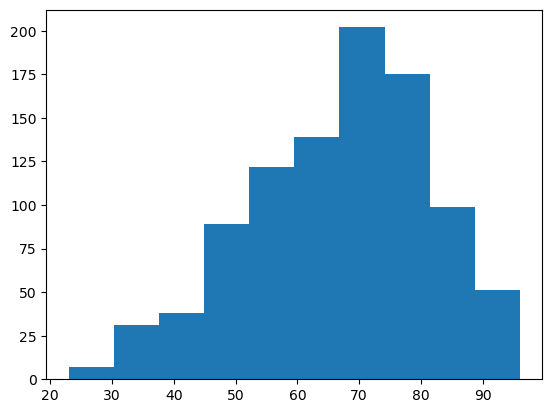

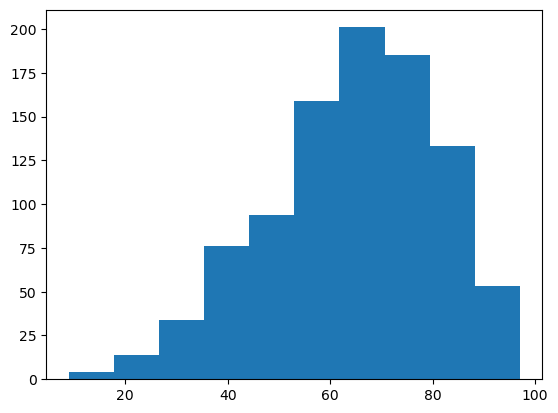

In [47]:
plt.hist(data['danceability_%'])
plt.show()
plt.hist(data['energy_%'])
plt.show()

Does the mode of the song have any affect on the number of streams?

What about the song's bpm on chart rankings?

In [48]:
# Mode has almost no affect on the number of streams
print(data.groupby(by=['Minor'])['streams'].mean())

# Some BPMs seem a lot more popular than others.
# notable bpms to appear in charts multiple times (>10):
#   90, 92, 94, 96, 100, 105, 110, 120, 130, 140, 170
pd.options.display.max_rows = 150
data[data['in_spotify_charts'] > 0].groupby(by=['bpm'])['in_spotify_charts'].count()

Minor
False    5.338706e+08
True     4.859445e+08
Name: streams, dtype: float64


bpm
67      1
71      1
72      1
74      1
76      1
77      1
78      3
79      2
80      3
81      3
82      3
83      3
84      3
85      4
87      1
88      4
89      2
90     14
91      2
92     16
93      9
94     11
95     10
96     11
97      4
98     10
99      4
100    11
101     5
102     5
103     4
104     3
105    13
106     1
107     7
108     6
109     3
110    13
111     1
112     4
113     2
114     6
115     6
116     7
117     7
118     6
119     2
120    23
121     5
122    10
123     6
124     9
125    10
126     4
127     2
128    10
129     4
130    25
131     2
132     6
133     5
134     7
135     6
136     6
137     3
138     4
139     5
140    20
141     3
142     5
143     3
144     9
145     6
146     6
147     1
148     4
149     2
150    10
152     1
153     1
154     5
155     2
156     2
157     1
158     3
160     4
161     1
162     1
163     1
164     2
165     1
166     3
168     3
169     2
170    12
171     2
172     5
173     2
174     6
175   

#### 1.3 Feature Engineering
- Remove track & artist names.

    All track names are going to be different. Using artist names would inflate the number of dimensions, which seems to have diminishing returns since most artists are different.

In [49]:
# code here
# TODO: considering dropping apple/deezer data?

# Remove artist names/track name
data = data.drop(['track_name', 'artist(s)_name'], axis=1)


#### 1.4 Additional ML Tasks
>  If your dataset requires very little cleaning and/or feature engineering, then the points in this area should be earned by doing something additional in another area!
>
> This could include more thorough/more in-depth data exploration; performing anomaly detection on the data; performing and evaluating various clustering algorithms; implementing more advance modeling techniques or algorithms (beyond the models taught in class); or other things beyond what is listed here.

### 2. Modeling
- Describe process and models tested
- Going to test linear regression & KNN

In [54]:
# code here
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

data.dropna()
# print(data.head())

# simple modeling with streams and in_spotify
spotify = data["in_spotify_playlists"]
streams = data["streams"]
spotify = spotify.values.reshape(-1, 1)
streams = streams.values.reshape(-1, 1)
reg = LinearRegression()

r = cross_val_score(estimator=reg, X=spotify, y=streams, cv=5)
print("Simple regression on in_spotify vs streams: ")
print("Average R2: " + str(r.mean()))
print("Adjusted R2: " + str((1 - (1 - r) * ((spotify.shape[0] - 1) / 
          (spotify.shape[0] - spotify.shape[1] - 1))).mean()))

reg = LinearRegression()

# streams = data["streams"]
x=data.loc[:, data.columns != 'streams']
# x.apply(pd.to_numeric)


r = cross_val_score(estimator=reg, X=x, y=streams, cv=5, error_score='raise')
print("\nRegression on the entire dataset: ")

print("Average R2: " + str(r.mean()))
print("Adjusted R2: " + str((1 - (1 - r) * ((x.shape[0] - 1) / 
          (x.shape[0] - x.shape[1] - 1))).mean()))


Simple regression on in_spotify vs streams: 
Average R2: 0.48735618013674387
Adjusted R2: 0.4868171224923031

Regression on the entire dataset: 
Average R2: 0.5664961246480692
Adjusted R2: 0.5514177289836542


### 3. Results
- Describe results of final modeling